# Аналитика аудио ассортимента маркетплейса Digi-Key

**Цель** - провести аналитику ассортимента аудио товаров маркетплейса [Digi-Key](https://www.digikey.com/).

**Этапы проета:**
1. Выгрузка данных по API
2. Обзор данных
3. Предобработка данных
4. Исследовательский анализ данных

## Выгрузка данных Digi-Key

В Digi-Key API используется авторизация OAuth2. Для подключения к API необходимо сделать следующие шаги:

1. Регестрируемся на сайте https://developer.digikey.com
2. Создаем приложение и указывем:
    - Имя приложения.
    - Oauth Callback. В данном случае это https://localhost.
    - Описание приложения.
    - Тип приложения. В данном случае это "ProductInformation", т.к. остальные типы скорее нужны для активных действий. Тип "ProductInformation" больше подходит именно для сбора данных.
3. Запрашиваем код авторизации и предоставлем доступ к приложению:
    - Для этого необходимы Client_ID и Client Secret, которые можно посмотреть в своиствах приложения.
    - Эта информация вставляется в шаблон url-ссылки.
    - Далее при запуске url и при последующем предоставлении доступа к приложению возвращается код авторизации.
4. Получаем токен доступа.
    - Отправляем запрос на сервер с информацией о коде авторизации, id пользователя, секретном коде пользователя и тип предоставления доступа.
    - В ответ получаем токен тоступа и рефреш токен.
5. Возможно повтороное получение токена доступа (при необходимости). Токен доступа действует достаточно короткое время, поэтому разработчики предусмотрели его повторный запрос с помощью рефреш токена.

Ниже представлена схема авторизации с сайта (https://developer.digikey.com/documentation/oauth). На этом эе сайте подробно расписаны этапы авторизации.

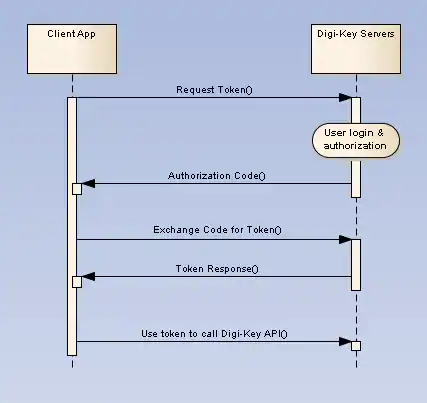

### Запрос access token

In [1]:
# загрузка библиотек
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Запрос access token.

In [2]:
codes = pd.read_csv('codes.csv')
client_id = codes['client_id'][0]
secret = codes['secret'][0]

In [3]:
BASE_URL = 'https://api.digikey.com/v1/oauth2/token'

params = {
        'code' : '',
        'client_id' : client_id,
        'client_secret' : secret,
        'redirect_uri' : 'https://localhost',
        'grant_type' : 'authorization_code'
        }

response = requests.post(url=BASE_URL, data=params) 
response.json()

{'access_token': 'nTdVQyU2V3rY1pEMv1pQVKnyX5VU',
 'refresh_token': 'EWdMisXceZUh8atAF84sGb0sofEmqi0N',
 'expires_in': 1798,
 'refresh_token_expires_in': 7775999,
 'token_type': 'Bearer'}

In [4]:
access_token = response.json()['access_token']
refresh_token = response.json()['refresh_token']

Для рефреша acess token создадим функцию.

In [5]:
def get_access_token_by_refresh(refresh_token):

    URL = 'https://api.digikey.com/v1/oauth2/token'

    data = {
            'client_id' : client_id,
            'client_secret' : secret,
            'refresh_token' : refresh_token,
            'grant_type' : 'refresh_token'
    }

    response = requests.post(url=URL, data=data)
    return response.json()

Ниже представлен запрос аксесс токена с помощью рефрештокена и сохранение его в переменную.

In [6]:
info = get_access_token_by_refresh(refresh_token)
access_token = info['access_token']
refresh_token = info['refresh_token']
info

{'access_token': '8BtBHG3YeM6ioeWuMR01G10U0YCq',
 'refresh_token': 'Tbsa4UTOAqJvrmkgudpB20R26X5TC5JT',
 'expires_in': 1799,
 'refresh_token_expires_in': 7775999,
 'token_type': 'Bearer'}

### Запрос данных

Запрос будет осуществляться через [KeywordSwearch](https://developer.digikey.com/products/product-information/partsearch/keywordsearch). Запишем функцию keword_search, которая будет запрашивать данные по ключевому слову. 

In [7]:
# keyword - ключевое слово
# record_count - количество продуктов в запросе (макс. - 50)
# record_start_position - номер позиции в поиске с которой будет возвращаться данные

def keyword_search(keyword, record_count, record_start_position):
    
    URL = 'https://api.digikey.com/Search/v3/Products/Keyword'

    headers = {
        'Authorization' : 'Bearer {}'.format(access_token),
        'X-DIGIKEY-Client-Id' : client_id
        }

    json_data = {
      "Keywords": "{}".format(keyword),
      "RecordCount": record_count,
      "RecordStartPosition": record_start_position}

    response = requests.post(url=URL, headers=headers, json=json_data)
    
    # сохранение запроса в формате json
    response_json = response.json()
    return response_json

Запрос выводит достаточно много параметром продукта. Для дальнейшей записи в дата фрейм выберем на мой взгляд самые важные и те, которые могут пригодиться в дальнейшем анализе:
- DigiKeyPartNumber - уникальный Dig-Key номер продукта;
- ProductDescription - краткое описание продукта;
- SupplierDirectShip - прямая доставка от поставщика;
- UnitPrice - цена продукции;
- QuantityAvailable - количество продукции;
- NonStock - отсутствие в наличии;
- ProductUrl - ссылка на продукцию;
- Category - категориия продукта;
- Family - класс продукта;
- Packaging - тип упаковки;
- Manufacturer - производитель.

Ниже приведен код, котрый делает несколько запросов в зависимости от количества уникальных товаров и записывает значения параметров в датафрейм. Попробуем подгрузить и в дальнейшем проанализировать товары по ключевому слову "audio".

In [8]:
# параметры товаров
features = [
            'DigiKeyPartNumber', 
            'ProductDescription',
            'SupplierDirectShip',
            'UnitPrice',
            'QuantityAvailable',
            'NonStock',
            'ProductUrl'
            ]

# не все параметры в запросе это параметры
# пречисленные ниже, это значения параметров
features_with_values = [
                        'Category',
                        'Family',
                        'Packaging',
                        'Manufacturer'
                       ]
# основной код
# назначение переменных
product_info = pd.DataFrame()
keyword = 'audio'
record_count = 50
record_start_position = 0 
    
# тестовый запрос
test_response = keyword_search(keyword, record_count, record_start_position)
products_count = test_response['ProductsCount']

    
# цикл на запрос (запрашивается 50 товаров за одну итерацию (max))
while record_start_position < products_count:
    response = keyword_search(keyword, record_count, record_start_position)
       
    # условие необходимое для корректного завершения цикла
    if (products_count - record_start_position) < 50:
        record_count = products_count - record_start_position
        
    # цикл для записи в датафрейм значений features
    i = 0
    while i < record_count:
        for feature in features:
            product_info.at[record_start_position + i, feature] = response['Products'][i][feature]

        i += 1
        
        # цикл для записи в датафрейм значений features_with_values
    i = 0
    while i < record_count:
        for feature_with_value in features_with_values:        
            product_info.at[record_start_position + i, feature_with_value] = (response['Products'][i]
                                                                              [feature_with_value]['Value'])   
        i += 1

    record_start_position += record_count

Сохраним запрос в csv файл.

In [9]:
product_info.to_csv('product_info_audio.csv', index=False)

## Обзор данных

Подгрузим данные.

In [10]:
product_info = pd.read_csv('product_info_audio.csv')

Проведём обзор.

In [11]:
# Функция обзора данных
def first_look(df):
    print('----------Первые 5 строк----------')
    display(df.head())
    print('\n')
    print('----------Тип данных----------')
    display(df.info())
    print('----------Пропуски в данных----------')
    df_isna = df.isna().sum()
    if df_isna.sum() > 0:
        print(df_isna)
    else: print('Пропусков нет')
    print()
    print('----------Количество явных дубликатов----------')
    print(df.duplicated().sum())

In [12]:
first_look(product_info)

----------Первые 5 строк----------


,DigiKeyPartNumber,ProductDescription,SupplierDirectShip,UnitPrice,QuantityAvailable,NonStock,ProductUrl,Category,Family,Packaging,Manufacturer
0,3475-AT4365-ND,Audio Transformer,False,4.50,10.0,False,https://www.digikey.com/en/products/detail/all...,Transformers,Audio Transformers,Box,Allied Components International
1,3475-AT4547-ND,AUDIO TRANSFORMER,False,9.95,161.0,False,https://www.digikey.com/en/products/detail/all...,Transformers,Audio Transformers,Tray,Allied Components International
2,3475-AT3945TR-ND,Audio Transformer,False,4.50,10.0,False,https://www.digikey.com/en/products/detail/all...,Transformers,Audio Transformers,Tape & Reel (TR),Allied Components International
3,3475-AEI19-4660-ND,AUDIO TRANSFORMER,False,5.75,3.0,False,https://www.digikey.com/en/products/detail/all...,Transformers,Audio Transformers,Tray,Allied Components International
4,237-1155-ND,TRANS 600/ 600 OHM AUDIO,False,19.92,3890.0,False,https://www.digikey.com/en/products/detail/tri...,Transformers,Audio Transformers,Bulk,Triad Magnetics




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21850 entries, 0 to 21849
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DigiKeyPartNumber   21850 non-null  object 
 1   ProductDescription  21850 non-null  object 
 2   SupplierDirectShip  21850 non-null  bool   
 3   UnitPrice           21850 non-null  float64
 4   QuantityAvailable   21850 non-null  float64
 5   NonStock            21850 non-null  bool   
 6   ProductUrl          21550 non-null  object 
 7   Category            21850 non-null  object 
 8   Family              21850 non-null  object 
 9   Packaging           21850 non-null  object 
 10  Manufacturer        21850 non-null  object 
dtypes: bool(2), float64(2), object(7)
memory usage: 1.5+ MB


None

----------Пропуски в данных----------
DigiKeyPartNumber       0
ProductDescription      0
SupplierDirectShip      0
UnitPrice               0
QuantityAvailable       0
NonStock                0
ProductUrl            300
Category                0
Family                  0
Packaging               0
Manufacturer            0
dtype: int64

----------Количество явных дубликатов----------
2953


- Наблюдаются явные дубликаты.
- Данные в столбце `ProductDescription` нужно привести к нижнему регистру.
- Обнаружены пропуски в  столбце `ProductUrl`. Данный столбец имеет справочный характер.

## Предобработка данных

### Приведение данных к нижнему регистру

In [13]:
product_info['ProductDescription'] = product_info['ProductDescription'].str.lower()

In [14]:
product_info['ProductDescription'][:5]

0           audio transformer
1           audio transformer
2           audio transformer
3           audio transformer
4    trans 600/ 600 ohm audio
Name: ProductDescription, dtype: object

Данные описания товаров приведены к нижнему регистру.

### Поиск дубликатов

Проверим на дубликаты столбец уникальными номерами товаров `DigiKeyPartNumber`.

In [15]:
product_info['DigiKeyPartNumber'].duplicated().sum()

2961

Их чуть больше чем явных.

### Удаление дубликатов 

In [16]:
product_info = product_info.drop_duplicates().drop_duplicates('DigiKeyPartNumber')

In [17]:
len(product_info)

18889

Дубликаты успешно удалены. 

### Добавление столбца с суммарной стоимостью товаров

Для добавление такого столбца перемножим `UnitPrice` и `QuantityAvailable`.

In [18]:
product_info['SumPrice'] = product_info['UnitPrice'] * product_info['QuantityAvailable']

## Исследовательский анализ данных

### Средняя цена

Посмотрим на распределение средней цены товаров.

In [19]:
product_info['UnitPrice'].describe(percentiles = [.01,.25,.75,.99])

count    18889.000000
mean        73.329611
std        556.769228
min          0.000000
1%           0.000000
25%          0.980000
50%          3.700000
75%         19.980000
99%       1073.800000
max      25000.000000
Name: UnitPrice, dtype: float64

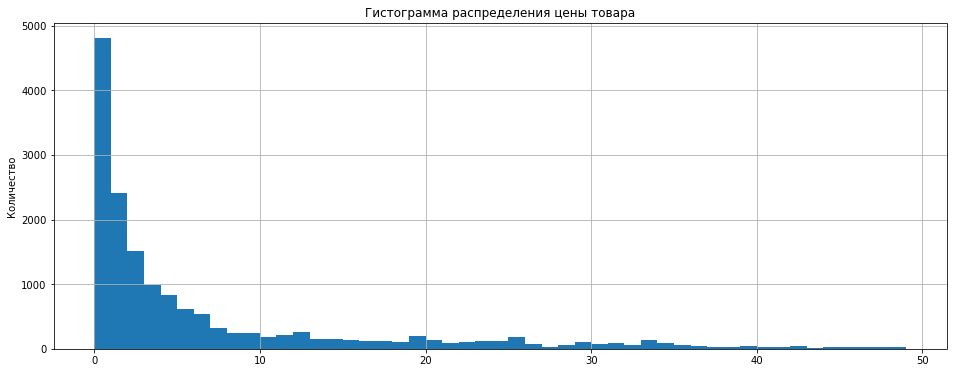

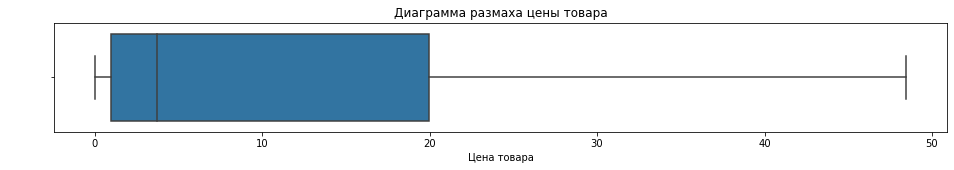

In [20]:
#гистограмма распределения
plt.figure(figsize=(16,6))
product_info['UnitPrice'].hist(range=(0, 49), bins=49)
plt.title('Гистограмма распределения цены товара')
plt.ylabel('Количество')

# диаграмма размаха
plt.figure(figsize=(16,2))
sns.boxplot(data=product_info, x = 'UnitPrice', showfliers = False)
plt.title('Диаграмма размаха цены товара')
plt.xlabel('Цена товара')
plt.ylabel('                       ', rotation=0);

Основная масса товаров сосредоточена в диапазоне цены от 1 до 20 долларов. При этом максимальная цена товара достигает 25 000$. Посмотрим на него:

In [21]:
product_info[product_info['UnitPrice'] == 25000]

,DigiKeyPartNumber,ProductDescription,SupplierDirectShip,UnitPrice,QuantityAvailable,NonStock,ProductUrl,Category,Family,Packaging,Manufacturer,SumPrice
13558,2197-TK-U47-MP-ND,telefunken u47 matched pair,False,25000.0,0.0,False,https://www.digikey.com/en/products/detail/tub...,Audio Products,Vacuum Tubes,Bulk,Telefunken,0.0


In [22]:
pd.options.display.max_colwidth = 100
product_info[product_info['UnitPrice'] == 25000]['ProductUrl']

13558    https://www.digikey.com/en/products/detail/tubedepot/TK-U47-MP/10489769
Name: ProductUrl, dtype: object

### Категория продукта 

Выведем список уникальных категорий.

In [23]:
sorted(list(product_info['Category'].unique()))

['Anti-Static, ESD, Clean Room Products',
 'Audio Products',
 'Boxes, Enclosures, Racks',
 'Cable Assemblies',
 'Cables, Wires',
 'Cables, Wires - Management',
 'Capacitors',
 'Computer Equipment',
 'Connectors, Interconnects',
 'Development Boards, Kits, Programmers',
 'Discrete Semiconductor Products',
 'Embedded Computers',
 'Filters',
 'Hardware, Fasteners, Accessories',
 'Inductors, Coils, Chokes',
 'Industrial Automation and Controls',
 'Industrial Supplies',
 'Integrated Circuits (ICs)',
 'Kits',
 'Maker/DIY, Educational',
 'Motors, Actuators, Solenoids and Drivers',
 'Networking Solutions',
 'Optoelectronics',
 'Potentiometers, Variable Resistors',
 'RF/IF and RFID',
 'Resistors',
 'Sensors, Transducers',
 'Switches',
 'Test and Measurement',
 'Tools',
 'Transformers',
 'Uncategorized']

Посчитаем доли классов по количеству товара.

In [24]:
product_info['Category'].value_counts(normalize=True)[:10].map('{:.2%}'.format)

Audio Products                           40.33%
Integrated Circuits (ICs)                28.49%
Connectors, Interconnects                 9.05%
Capacitors                                7.75%
Development Boards, Kits, Programmers     3.58%
Transformers                              3.25%
Potentiometers, Variable Resistors        1.73%
Cable Assemblies                          1.32%
Cables, Wires                             1.32%
Networking Solutions                      0.47%
Name: Category, dtype: object

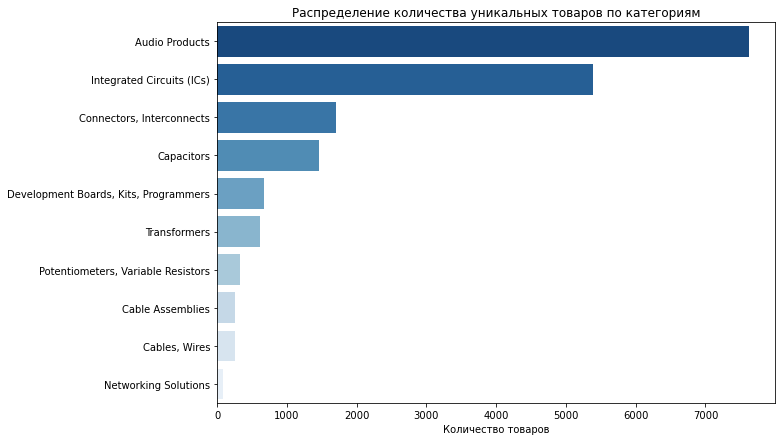

In [25]:
plt.figure(figsize=(10, 7))
sns.barplot(x = product_info['Category'].value_counts()[:10].values, 
            y = product_info['Category'].value_counts(normalize=True)[:10].index, palette='Blues_r')
plt.title('Распределение количества уникальных товаров по категориям')
plt.xlabel('Количество товаров');

В лидерах аудио товары :)
Также достаточно большую долю занимает категория интегральных схем.

Взглянем на среднюю цену, общую сумму, общее количество товаров по категориям.

In [26]:
category_stat = (
                product_info.groupby('Category')
                [['UnitPrice', 'QuantityAvailable', 'SumPrice', 'DigiKeyPartNumber']]
                .agg
                    (
                    {
                     'UnitPrice' : 'mean',
                     'QuantityAvailable' : 'sum',
                     'SumPrice' : 'sum',
                     'DigiKeyPartNumber' : 'count'
                     }
                     )
                .sort_values(by='SumPrice', ascending=False)
                )

category_stat.columns = ['unit_price', 'qantity_sum', 'sum_price', 'count']
category_stat.style.format(
                            {
                             'unit_price' : '${:.0f}',
                             'qantity_sum' : '{:.0f}',
                             'sum_price' : '${:.0f}',
                             'count' : '{:.0f}',
                            }
                           )

,unit_price,qantity_sum,sum_price,count
Category,,,,
Integrated Circuits (ICs),$4,65677879,$157663948,5382
Audio Products,$54,24050837,$70307612,7617
"Connectors, Interconnects",$10,4658540,$9072756,1710
Transformers,$51,453564,$2583219,613
Networking Solutions,$860,1744,$1854673,88
Capacitors,$3,1452144,$1709085,1463
"Cables, Wires",$617,5568,$1345835,250
Computer Equipment,$667,1887,$1294641,78
Cable Assemblies,$24,203467,$1198053,250


- В лидерах по общей стоимости интегральные схемы. Однако средняя цена одной штуки товара одна из самых низких. Высокая общая стоимость обусловлена большим количеством товаров данной категории.
- Аудио товары на втором месте. Их количество меньше примерно в два раpа в сравнении с интегральными схемами, однако средняя стоимость гораздо выше.
- Стоит отметить категорию встраиваемых систем ('Embedded Computers'). Их средняя цена значительно выше цены товаров остальных категорий.

Посмотрим распределение цены товаров по категориям (топ-15 по средней цене). Категорию 'Embedded Computers' исключим, т.к. с её учетом остальные категории будут плохо различимы на графике.

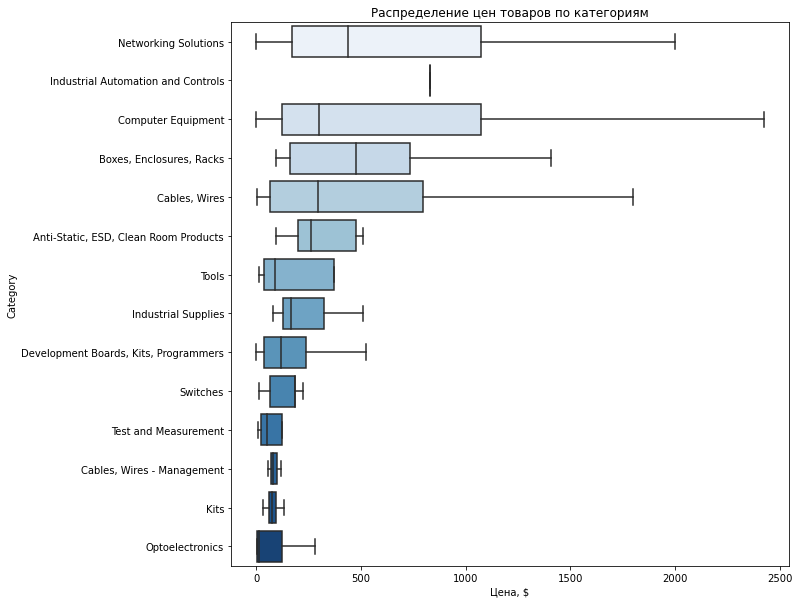

In [27]:
# построеие графика ящик с усами
top_15_category = list(category_stat.sort_values(by='unit_price', ascending=False).index)[1:15]
plt.figure(figsize=(10, 10))
sns.boxplot(
           x="UnitPrice", y="Category",
           data=product_info[product_info['Category'].isin(top_15_category)],
           palette='Blues',
           orient='h',
           showfliers = False,
           order = top_15_category
           )
plt.title('Распределение цен товаров по категориям')
plt.xlabel('Цена, $');

- Большинсто товаров в категориях расположены между пятидесяти процентном и девяностопятипроцентном процентилями. Исключением является категория 'Boxes, Enclosures, Racks', в которой медиана средней цены смещена вправо.
- В категории 'Industrial Automation and Controls' представлен лишь один уникальный товар.

### Производитель

Рассмотрим топ 10 компаний по денежному объему на маркетплейсе.

In [28]:
category_stat = (
                product_info.groupby('Manufacturer')
                [['UnitPrice', 'QuantityAvailable', 'SumPrice', 'DigiKeyPartNumber']]
                .agg
                    (
                    {
                     'UnitPrice' : 'mean',
                     'QuantityAvailable' : 'sum',
                     'SumPrice' : 'sum',
                     'DigiKeyPartNumber' : 'count'
                     }
                     )
                .sort_values(by='SumPrice', ascending=False)
                )

category_stat.columns = ['unit_price', 'qantity_sum', 'sum_price', 'count']
category_stat[:10].style.format(
                            {
                             'unit_price' : '${:.0f}',
                             'qantity_sum' : '{:.0f}',
                             'sum_price' : '${:.0f}',
                             'count' : '{:.0f}',
                            }
                           )

,unit_price,qantity_sum,sum_price,count
Manufacturer,,,,
Texas Instruments,$24,17164369,$56231398,2342
Floyd Bell Inc,$28,897172,$24964658,908
Renesas Electronics America Inc,$7,1597153,$22426801,89
Analog Devices Inc.,$32,4886557,$21788926,463
onsemi,$5,25299591,$20058791,425
CUI Devices,$3,7070383,$11546950,1058
Cirrus Logic Inc.,$60,1468269,$10637599,412
"PUI Audio, Inc.",$4,4060509,$10451217,1119
TDK InvenSense,$12,3462147,$7571504,106


Texas Instruments наиболее "объемная" компания.

Посмотрим распределение цен товаров по этим компаниям.

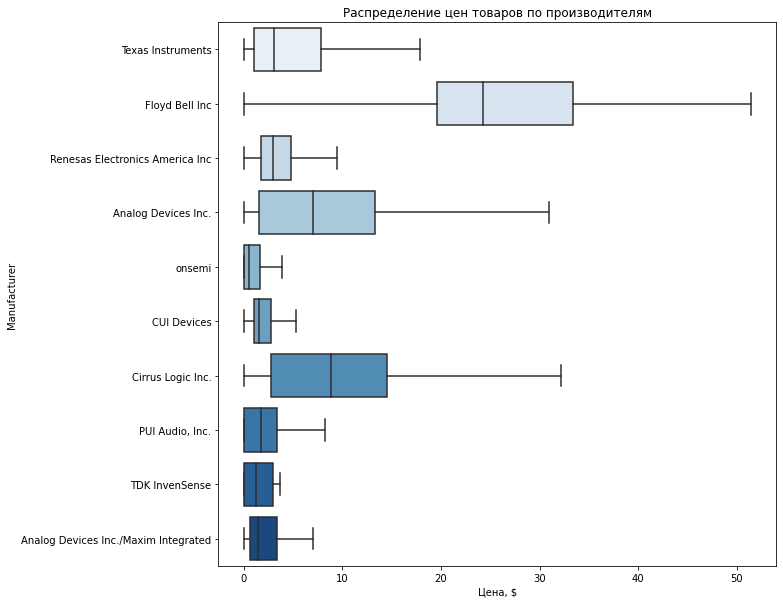

In [29]:
# построеие графика ящик с усами
top_10_manufacturer = list(category_stat.sort_values(by='sum_price', ascending=False).index)[:10]
plt.figure(figsize=(10, 10))
sns.boxplot(
           x="UnitPrice", y="Manufacturer",
           data=product_info[product_info['Manufacturer'].isin(top_10_manufacturer)],
           palette='Blues',
           orient='h',
           showfliers = False,
           order = top_10_manufacturer
           )
plt.title('Распределение цен товаров по производителям')
plt.xlabel('Цена, $');

- Несмотря на то, что Texax Instruments первые по объёмам цены на их товары относительно невысокие.
- Наиболее дорогие товары характерны для Floyd Bell inc, которая специализируется на аудиотоварах.
- Также дороже остальных продаются товары компаний Analog Devices inc. и Cirrus Logic inc.

Посмотрим какие категории товаров представляют эти компании.

In [30]:
data_manufacturer = product_info[product_info['Manufacturer'].isin(top_10_manufacturer)] 
top_10_manufacturer_group = data_manufacturer.groupby(['Manufacturer', 'Category'])['DigiKeyPartNumber'].count()
top_10_manufacturer_group

Manufacturer                          Category                                
Analog Devices Inc.                   Audio Products                                 2
                                      Development Boards, Kits, Programmers         36
                                      Discrete Semiconductor Products                1
                                      Integrated Circuits (ICs)                    424
Analog Devices Inc./Maxim Integrated  Development Boards, Kits, Programmers         30
                                      Integrated Circuits (ICs)                    488
                                      RF/IF and RFID                                 6
CUI Devices                           Audio Products                               632
                                      Connectors, Interconnects                    420
                                      Development Boards, Kits, Programmers          1
                                      Kits         

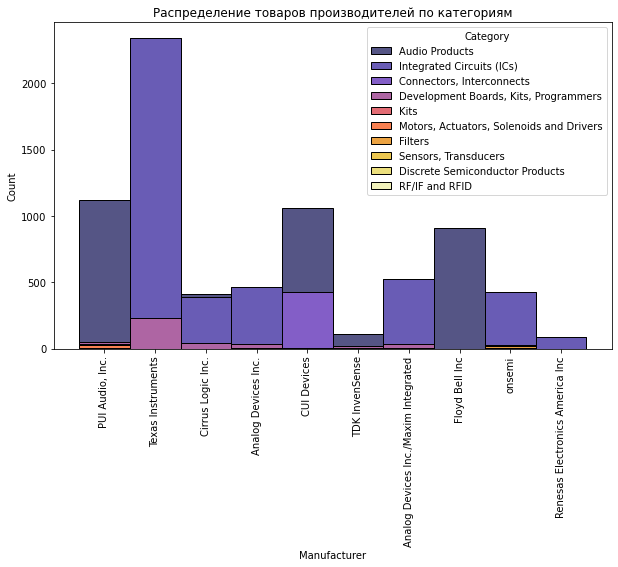

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=product_info[product_info['Manufacturer'].isin(top_10_manufacturer)],
             x="Manufacturer", hue="Category",  multiple="stack", palette='CMRmap')
plt.title('Распределение товаров производителей по категориям')
plt.xticks(rotation=90);

- Аудио товары характерны для:
    - PUI Audio
    - CIU Devices
    - Floyd Bell inc.
- CUI Devices также занимает нишу коннекторов.
- Остальные компании занимают нишу интегральых схем. И безусловный лидер здесь это Texas Instruments.

### Упаковка

Посмотрим на соотношение вида упаковок товара.

In [32]:
product_info['Packaging'].value_counts(normalize=True).map('{:.2%}'.format)

Bulk                             47.81%
Tray                             11.63%
Tape & Reel (TR)                  9.38%
Cut Tape (CT)                     8.58%
Digi-Reel®                        6.94%
Box                               5.42%
Tube                              4.32%
Tape & Box (TB)                   1.59%
Bag                               1.57%
Retail Package                    1.41%
Spool                             0.78%
Case                              0.40%
Strip                             0.07%
-                                 0.05%
Book                              0.03%
Sheet                             0.02%
Digi-Spool®, Continuous Spool     0.01%
Name: Packaging, dtype: object

Самая популярная упаковка - Bulk (массовая). Это говорит нам о том, что скорее всего, продукция не продается поштучно.

### Доставка поставщика

In [33]:
product_info['SupplierDirectShip'].value_counts(normalize=True).map('{:.2%}'.format)

False    100.00%
Name: SupplierDirectShip, dtype: object

Нет ни одного поставщика, который собственноручно доставляет продукцию.

### Количество распроданного товара

Посчитаем долю распроданного товара.

In [34]:
product_info['NonStock'].value_counts(normalize=True).map('{:.2%}'.format)

False    75.41%
True     24.59%
Name: NonStock, dtype: object

Посмотрим товары каких производителей были преимущественно распроданы.

In [35]:
product_non_stock = (
    product_info.groupby(['Manufacturer', 'NonStock'])['DigiKeyPartNumber']
    .size()
    .unstack(fill_value=0)
)

product_non_stock['all_prod'] = product_non_stock[False] + product_non_stock[True]
product_non_stock[True] = (product_non_stock[True]/product_non_stock['all_prod']).map('{:.2%}'.format)
product_non_stock[False] = (product_non_stock[False]/product_non_stock['all_prod']).map('{:.2%}'.format)

In [36]:
product_non_stock.sort_values(by='all_prod', ascending=False)[:10]

NonStock,False,True,all_prod
Manufacturer,,,
Texas Instruments,59.82%,40.18%,2342
Nichicon,95.48%,4.52%,1128
"PUI Audio, Inc.",60.86%,39.14%,1119
CUI Devices,73.35%,26.65%,1058
TubeDepot,100.00%,0.00%,1047
Knowles,22.45%,77.55%,962
Floyd Bell Inc,100.00%,0.00%,908
Analog Devices Inc./Maxim Integrated,56.87%,43.13%,524
Switchcraft Inc.,96.08%,3.92%,485


Распроданных или отсутствующих товаров на маркет плейсе достаточно много – 25%. Их также много у самой "объемной" компании Texax Instruments. В дальнейшем следует осуществить анализ товаров, которые есть в наличии.

## Выводы

1. Выгрузка данных по API.
    - Проведена авторизация.
    - Выгружены данные по поисковому запросу "audio" с помощью API инструмента KeywordSearch.
    - Значенения выделенных параметров записаны в csv.
2. Обзор данных
    - Были обнаружены явные дубликаты.
    - Данные в столбце `ProductDescription` с разным регистром.
    - Обнаружены пропуски в  столбце `ProductUrl`.Однако, данный столбец имеет справочный характер.
3. Предобработка данных
    - Удалены дубликаты.
    - Столбец `ProductDescription` приведён к нижнему регистру.
4. Исследовательский анализ данных
    - По количеству уникальных товаров лидирует категория аудио товары.
    - Достаточно большую долю занимают интегральные схемы.
    - В лидерах по общей стоимости также интегральные схемы. Однако средняя цена одной штуки товара одна из самых низких. 
    - Аудио товары на втором месте. Их количество меньше примерно в два раpа в сравнении с интегральными схемами, однако средняя стоимость гораздо выше.
    - Стоит отметить категорию встраиваемых систем ('Embedded Computers'). Их средняя цена значительно выше цены товаров остальных категорий.
    - Texax Instruments наиболее объемная компания в маркетплейсе. Но несмотря на это стоимость их товаров относительно невысокая.
    - Наиболее дорогие товары характерны для Floyd Bell inc, которая специализируется на аудиотоварах.
    - Также дороже остальных продаются товары компаний Analog Devices inc. и Cirrus Logic inc.
    - Аудио товары характерны для следующих компаний:
        - PUI Audio
        - CIU Devices
        - Floyd Bell inc.
    - CUI Devices также занимает нишу коннекторов.
    - Остальные компании занимают нишу интегральых схем. И безусловный лидер здесь это Texas Instruments.
    - Самая популярная упаковка товаров - Bulk (массовая). Это говорит нам о том, что скорее всего, продукция не продается поштучно.
    - Распроданных или отсутствующих товаров на маркет плейсе достаточно много – 25%. Их также много у самой "объемной" компании Texax Instruments. В дальнейшем следует осуществить анализ товаров, котрые есть в наличии.